In [24]:
import tensorflow as tf
import keras
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import (BatchNormalization, Conv2D, Add, MaxPooling2D, Activation, Flatten, Dropout, Dense, UpSampling2D, GlobalAveragePooling2D)
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy, KLDivergence
from keras.metrics import CategoricalAccuracy
from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

170498071/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


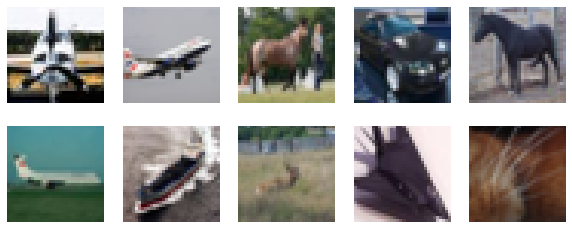

In [2]:
num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(10,4))
for j in range(2):
  for k in range(5):
    i = np.random.choice(range(len(x_train)))
    axes1[j][k].set_axis_off()
    axes1[j][k].imshow(x_train[i:i+1][0])
        

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [3]:
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [4]:
def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc = history_dict['categorical_accuracy']

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  acc_values = history_dict['categorical_accuracy']
  val_acc = history_dict['val_categorical_accuracy']

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

# ج)

In [18]:
#code taken from kaggle
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""




class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.upsample = UpSampling2D((7,7)) #resize 32*32 to 224*224
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes)

    def call(self, inputs):
        out = self.upsample(inputs)
        out = self.conv_1(out)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out



student_scratch = ResNet18(num_classes)
student_scratch.build(input_shape=(None, 32, 32, 3))
student_scratch.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=[CategoricalAccuracy()],
)
student_scratch.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_5 (UpSampling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_120 (Conv2D)         multiple                  9472      
                                                                 
 batch_normalization_120 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                             
                                                  

In [19]:
history = student_scratch.fit(x_train, y_train, epochs=4, batch_size=32, validation_data=(x_test, y_test),shuffle=True)

Epoch 1/4
1563/1563 [==============================] - 197s 113ms/step - loss: 1.2451 - categorical_accuracy: 0.5529 - val_loss: 1.2976 - val_categorical_accuracy: 0.5612
Epoch 2/4
1563/1563 [==============================] - 176s 113ms/step - loss: 0.7956 - categorical_accuracy: 0.7204 - val_loss: 1.0342 - val_categorical_accuracy: 0.6697
Epoch 3/4
1563/1563 [==============================] - 177s 113ms/step - loss: 0.5749 - categorical_accuracy: 0.8002 - val_loss: 1.0248 - val_categorical_accuracy: 0.6771
Epoch 4/4
1563/1563 [==============================] - 177s 113ms/step - loss: 0.4038 - categorical_accuracy: 0.8590 - val_loss: 0.8828 - val_categorical_accuracy: 0.7231


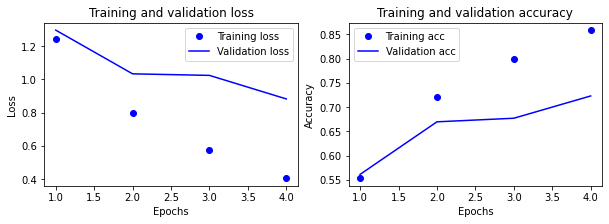

313/313 [==============================] - 10s 32ms/step - loss: 0.8828 - categorical_accuracy: 0.7231
Test accuracy of Student Model from Scratch: 0.7231000065803528


In [20]:
visualize_loss_and_acc(history)
# Score trained model.
scores = student_scratch.evaluate(x_test, y_test, verbose=1)
print('Test accuracy of Student Model from Scratch:', scores[1])

### I checked batch_size = 32,64 / learning_rate = 1e-3,1e-4,2e-5 / epochs = 5,10 and kept the best results above (highest accuracy, early stopped)

- ResNet18 is smaller then ResNet50. so it has higher loss and less accuracy compared to even a linear-tuned ResNet50.
- It also has less accuracy compared to best model we achieved using knowledge distillation (79.87% compared to 72.31%).The teacher model was fine-tuned on CIFAR-10 (not completely but acceptable enough to improve performance of a smaller model like ResNet18) so it could help student model to achieve higher accuracy and converge faster.

# د)

In [21]:
conv_base = ResNet50(weights='imagenet', include_top=False,pooling='avg',input_shape=(224, 224, 3))

teacher_allTune = Sequential()
teacher_allTune.add(UpSampling2D((7,7)))
teacher_allTune.add(conv_base)
teacher_allTune.add(Dense(num_classes))

#teacher_allTune.layers[1].name,teacher_allTune.layers[1].trainable
teacher_allTune.build(input_shape=(None, 32, 32, 3))
teacher_allTune.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_6 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_7 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [22]:
teacher_allTune.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=[CategoricalAccuracy()],
)
history = teacher_allTune.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test),shuffle=True)

Epoch 1/5
782/782 [==============================] - 550s 692ms/step - loss: 0.3214 - categorical_accuracy: 0.8929 - val_loss: 0.2038 - val_categorical_accuracy: 0.9343
Epoch 2/5
782/782 [==============================] - 539s 689ms/step - loss: 0.0930 - categorical_accuracy: 0.9691 - val_loss: 0.2640 - val_categorical_accuracy: 0.9164
Epoch 3/5
782/782 [==============================] - 539s 689ms/step - loss: 0.0588 - categorical_accuracy: 0.9811 - val_loss: 0.2527 - val_categorical_accuracy: 0.9295
Epoch 4/5
782/782 [==============================] - 539s 690ms/step - loss: 0.0486 - categorical_accuracy: 0.9837 - val_loss: 0.3317 - val_categorical_accuracy: 0.9103
Epoch 5/5
782/782 [==============================] - 539s 690ms/step - loss: 0.0446 - categorical_accuracy: 0.9851 - val_loss: 0.2417 - val_categorical_accuracy: 0.9323


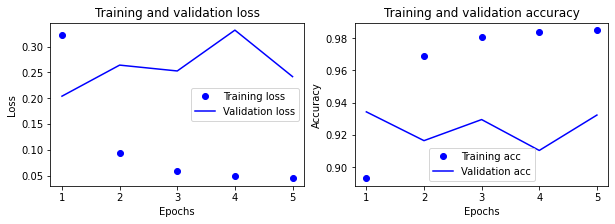

313/313 [==============================] - 31s 95ms/step - loss: 0.2417 - categorical_accuracy: 0.9323
Test accuracy: 0.9322999715805054


In [23]:
visualize_loss_and_acc(history)
# Score trained model.
scores = teacher_allTune.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

like the first part of this question, I tried to resolve overfit problem by normalizing dataset. although ResNet50 was not overfit anymore it had the same accuracy and loss compared to this model. normalized dataset didn't work out pretty well for training ResNet18 and my results for knowledge distillation model were not good. so I didn't normalize the dataset at the end

In [25]:
#code taken from https://keras.io/examples/vision/knowledge_distillation/
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3.,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [26]:
# Initialize and compile distiller
student = ResNet18(10)
distiller = Distiller(student=student, teacher=teacher_allTune)
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate =1e-4),
    metrics=[CategoricalAccuracy()],
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn= KLDivergence(),
    alpha=0.1,
    temperature=10.,
)

# Distill teacher to student
history = distiller.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/5
1563/1563 [==============================] - 331s 209ms/step - categorical_accuracy: 0.5523 - student_loss: 2.1414 - distillation_loss: 16.2871 - val_categorical_accuracy: 0.6578 - val_student_loss: 2.5730
Epoch 2/5
1563/1563 [==============================] - 326s 209ms/step - categorical_accuracy: 0.7274 - student_loss: 1.3522 - distillation_loss: 9.5404 - val_categorical_accuracy: 0.7222 - val_student_loss: 1.4665
Epoch 3/5
1563/1563 [==============================] - 327s 209ms/step - categorical_accuracy: 0.8006 - student_loss: 0.9354 - distillation_loss: 6.8554 - val_categorical_accuracy: 0.7668 - val_student_loss: 1.3619
Epoch 4/5
1563/1563 [==============================] - 327s 209ms/step - categorical_accuracy: 0.8467 - student_loss: 0.6756 - distillation_loss: 5.2973 - val_categorical_accuracy: 0.7892 - val_student_loss: 1.5028
Epoch 5/5
1563/1563 [==============================] - 327s 209ms/step - categorical_accuracy: 0.8826 - student_loss: 0.4769 - distillation

In [27]:
# Evaluate student on test dataset
scores = distiller.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy of Student Model: ", scores[0])

313/313 [==============================] - 10s 33ms/step - categorical_accuracy: 0.8169 - student_loss: 0.9395
Test Accuracy of Student Model:  0.8169000148773193


In [28]:
# Initialize and compile distiller
student = ResNet18(10)
distiller = Distiller(student=student, teacher=teacher_allTune)
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate =1e-4),
    metrics=[CategoricalAccuracy()],
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn= KLDivergence(),
    alpha=0.05,
    temperature=15.,
)

# Distill teacher to student
history = distiller.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/5
1563/1563 [==============================] - 331s 209ms/step - categorical_accuracy: 0.5566 - student_loss: 2.1410 - distillation_loss: 14.5942 - val_categorical_accuracy: 0.6004 - val_student_loss: 2.3200
Epoch 2/5
1563/1563 [==============================] - 326s 208ms/step - categorical_accuracy: 0.7239 - student_loss: 1.3669 - distillation_loss: 8.7536 - val_categorical_accuracy: 0.6782 - val_student_loss: 1.9576
Epoch 3/5
1563/1563 [==============================] - 326s 208ms/step - categorical_accuracy: 0.8009 - student_loss: 0.9428 - distillation_loss: 6.3494 - val_categorical_accuracy: 0.7864 - val_student_loss: 1.2187
Epoch 4/5
1563/1563 [==============================] - 326s 209ms/step - categorical_accuracy: 0.8432 - student_loss: 0.6976 - distillation_loss: 5.0152 - val_categorical_accuracy: 0.7559 - val_student_loss: 1.5951
Epoch 5/5
1563/1563 [==============================] - 327s 209ms/step - categorical_accuracy: 0.8784 - student_loss: 0.5184 - distillation

In [29]:
# Evaluate student on test dataset
scores = distiller.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy of Student Model: ", scores[0])

313/313 [==============================] - 10s 33ms/step - categorical_accuracy: 0.7830 - student_loss: 1.1414
Test Accuracy of Student Model:  0.7829999923706055


In [30]:
# Initialize and compile distiller
student = ResNet18(10)
distiller = Distiller(student=student, teacher=teacher_allTune)
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate =1e-4),
    metrics=[CategoricalAccuracy()],
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn= KLDivergence(),
    alpha=0.01,
    temperature=10.,
)

# Distill teacher to student
history = distiller.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/5
1563/1563 [==============================] - 331s 210ms/step - categorical_accuracy: 0.5542 - student_loss: 2.1722 - distillation_loss: 16.1360 - val_categorical_accuracy: 0.6128 - val_student_loss: 2.1194
Epoch 2/5
1563/1563 [==============================] - 326s 209ms/step - categorical_accuracy: 0.7290 - student_loss: 1.3678 - distillation_loss: 9.4302 - val_categorical_accuracy: 0.7162 - val_student_loss: 1.8652
Epoch 3/5
1563/1563 [==============================] - 325s 208ms/step - categorical_accuracy: 0.8006 - student_loss: 0.9491 - distillation_loss: 6.8107 - val_categorical_accuracy: 0.7134 - val_student_loss: 2.2707
Epoch 4/5
1563/1563 [==============================] - 324s 207ms/step - categorical_accuracy: 0.8437 - student_loss: 0.7051 - distillation_loss: 5.3244 - val_categorical_accuracy: 0.7912 - val_student_loss: 0.4062
Epoch 5/5
1563/1563 [==============================] - 324s 207ms/step - categorical_accuracy: 0.8797 - student_loss: 0.5155 - distillation

In [31]:
# Evaluate student on test dataset
scores = distiller.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy of Student Model: ", scores[0])

313/313 [==============================] - 10s 33ms/step - categorical_accuracy: 0.7982 - student_loss: 1.0783
Test Accuracy of Student Model:  0.7982000112533569


- best model achieved using alpha=0.1 and T=10

- I kept the same learning rate(1e-4) and batch_size(32) of part b to make the comparisons fair.
- As we can see best model in part b was ( acc=79.87% loss=0.6009) while best model is part d is (acc=81.69% loss=0.9395)
- I think the raise in loss value is caused by overfit teacher model in part d.
- As CIFAR-10 & ImageNet have different data distributions, training the same structure on them would result in completely different weights. so in part a when we freezed the who structure and only changed the last layer to a 10-neuron FC (with no batch normalization, dropout or other extra FCs as it was not mentioned in HW description) the accuracy of model was around 83% and when we used this not-completely-fine-tuned model as a teacher for a weaker model in part b, the best result was 79.87%. 
- when we trained all the model parameters on CIFAR-10 in the last part (of course with a smaller learning rate) accuracy on test data reached 93.23% now the teacher model is more reliable compared to teacher model in part b and so we got slightly better accuracy for student model.
- In the link given for knowledge distillation introduction, it was mentioned that the authors got best results when alpha was way smaller than 1-alpha. Also as for temperature parameter, it was said that before running any tests we cannot be sure about how much detailed information student model can get from teacher model. so I tried (very)small values of alpha with different values of temperature.
